# Simple Linear Regression

In this Notebook, we will take a look at building a simple Linear regression model using PyTorch. This is a reference tutorial for myself and anyone who wants a direct to the point example of building a regression model using PyTorch. Please see below my reference, and places you can go to get more information on both the dataset I use and also a more indepth example of a regression model using PyTorch.

* [Dataset Source](https://www.kaggle.com/datasets/swathiachath/kc-housesales-data)
* [Code Source](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md)

Also, in this notebook we dont do any data analysis before building the model, we just jump into modelling.

In [1]:
import torch
import arrow
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
data_source = "https://raw.githubusercontent.com/ashdehghan/ML_DS_Data/main/simple_regression_data/kc_house_data/kc_house_data.csv"
data = pd.read_csv(data_source)

## Data Exploration

In this notebook, we are only going to build a model. The assumption is that we have done our data exploration somewhere else.
So, we will just jump into data cleansing and model building

## Data Prep

Here, we will clean and prep our data for model building.
We will do the following:
* Define the features and target columns.
* Remove any *nan* or *null* values.
* Split the data into Train, Validation and Test.
* Standardize the data.

Here, the goal is predict the price, so we know beforehand what column to select. Similarly for features, we know that columns *id* and *date* are not going to be meaningful.

Since the *price* for each house is linked to a given date, we consider our data to be of time-series type. So we will sort it based on date, and split our Train/Test accordingly. Not doing somthing like this is ok, it just means you are solving a different problem.

In [4]:
feature_cols = []
target_col = ["price"]
for col in data.columns:
    if col not in ["id", "price", "date"]:
        feature_cols.append(col)

In [5]:
def prep_data(data, feature_cols, target_col):
    data = data.copy(deep=True)
    data.dropna(inplace=True)
    data["date"] = data["date"].apply(lambda x : x.split("/")[2]+"-"+x.split("/")[0]+"-"+x.split("/")[1])
    data["date"] = data["date"].apply(lambda x : arrow.get(x, "YYYY-M-D"))
    data.sort_values(by=["date"], ascending=True, inplace=True)

    X = data[feature_cols].values
    y = data[target_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, data
    

X_train, X_val, X_test, y_train, y_val, y_test, data_mod = prep_data(data, feature_cols, target_col)

One thing we will check with the data is to see if there are any temporal trends in the data. For example if the prices are getting more and more expensive over time. From the plot below, we can see that this is not the case.

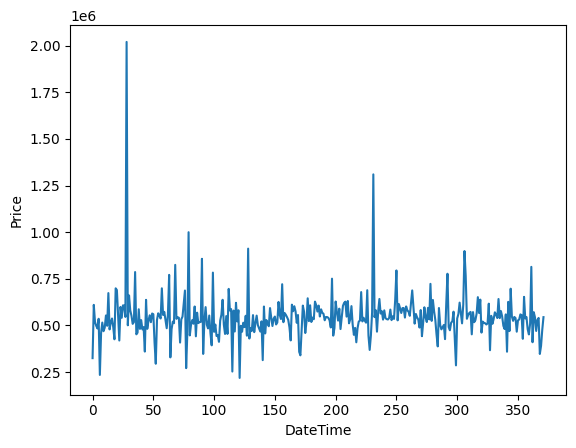

In [6]:
df = pd.DataFrame(data_mod.groupby(by=["date"])["price"].mean()).reset_index()
plt.plot(df["price"])
plt.xlabel("DateTime")
plt.ylabel("Price")
plt.show()

## Building the Model

The *Dataset* class handles the conversion of the *X* and *y* into PyTorch tensor and also implements a *len* and a *getitem* methods.

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        else:
            self.X = X
            self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

Now we can define the Multilayer Perceptron class, which is composed of a bunch of dense layers, and *ReLU* activations. Note that the last layer, outputs to a 1 dimensional and has no activate. This means it is a linear activation, which makes sense for a regression type problem.
The *forward* method, simply takes an input and pass it through the layers, and returns the output.

In [14]:
class MLP(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(input_dim, 32))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(32, 32))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(32, 1))

    def forward(self, x):
        output = self.layers(x)
        return output

Now, we actually train the model. Here are the key components:
* We can set the *device type* which could be *cpu* or *gpu* or *mps*.
* We define the *mlp* model, the *loss* function, which is a *Mean Absolute Error* and the optimizer, which in this case is *Adam*.
* We define the dataset and the *dataloader*, which helps with batching the data.
* We then loop through N number of *epochs*, and save the loss for validation and training.

In [16]:
device_type = "cpu"

input_dim = X_train.shape[1]

mlp = MLP(input_dim)
mlp.to(torch.device(device_type))

loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

X_train_mps = torch.from_numpy(X_train).float().to(device_type)
y_train_mps = torch.from_numpy(y_train).float().to(device_type)

dataset = Dataset(X_train_mps, y_train_mps)
trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    num_workers=0
)

inputs_val = torch.from_numpy(X_val).float().to(device_type)
targets_val = torch.from_numpy(y_val).float().to(device_type)
targets_val = targets_val.reshape((targets_val.shape[0], 1))

inputs_train = torch.from_numpy(X_train).float().to(device_type)
targets_train = torch.from_numpy(y_train).float().to(device_type)
targets_train = targets_train.reshape((targets_train.shape[0], 1))

val_loss = []
train_loss = []
for epoch in tqdm(range(1000)):

    for i, data in enumerate(trainloader, 0):

        inputs, targets = data
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()
        train_outputs = mlp(inputs)        
        loss = loss_function(train_outputs, targets)
        loss.backward()
        optimizer.step()

    y_val_pred = mlp(inputs_val)    
    val_loss.append(loss_function(y_val_pred, targets_val).item())
    
    y_train_pred = mlp(inputs_train)
    train_loss.append(loss_function(y_train_pred, targets_train).item())

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.54it/s]


## Analyzing the Model

A simple analysis is to look at the loss for train and validation. In normal cases, you want to optimize the training process based on how the validation loss improves. Once the validation loss stops improving and starts to the get worst, then you are entering the overfitting regieme and you want to do an early stopping.

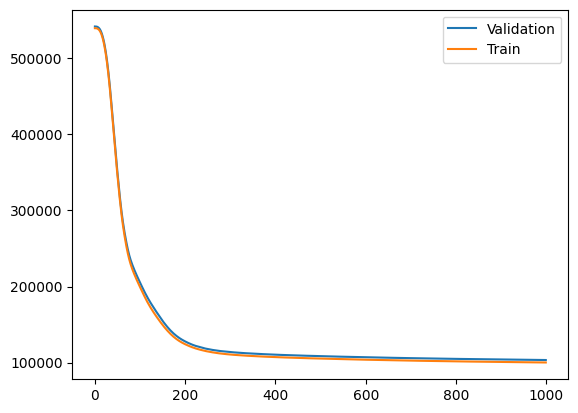

In [17]:
plt.plot(val_loss, label="Validation")
plt.plot(train_loss, label="Train")
plt.legend(loc="upper right")
plt.show()

In the above case we can see that the validation loss continues to improve along side train loss. This could be ok, if the model has learned some underlying logic to the data. You would need to do some additional analysis to figure this out.

Then you can test the model against the testset to see how it performs. Below we do some basic visual checks of the model.

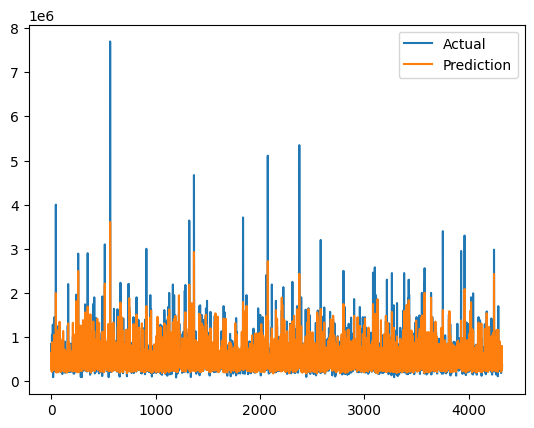

In [18]:
inputs_test = torch.from_numpy(X_test).float()
targets_test = torch.from_numpy(y_test).float()
targets_test = targets_test.reshape((targets_test.shape[0], 1))

test_pred = mlp(inputs_test).cpu().detach().numpy()

plt.plot(y_test.flatten(), label="Actual")
plt.plot(test_pred.flatten(), label="Prediction")
plt.legend(loc="upper right")
plt.show()